In [1]:
import numpy as np
import torch
from torch import nn
import tqdm

In [2]:
import torchvision
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split


### --Data Initialization--

106
12
40


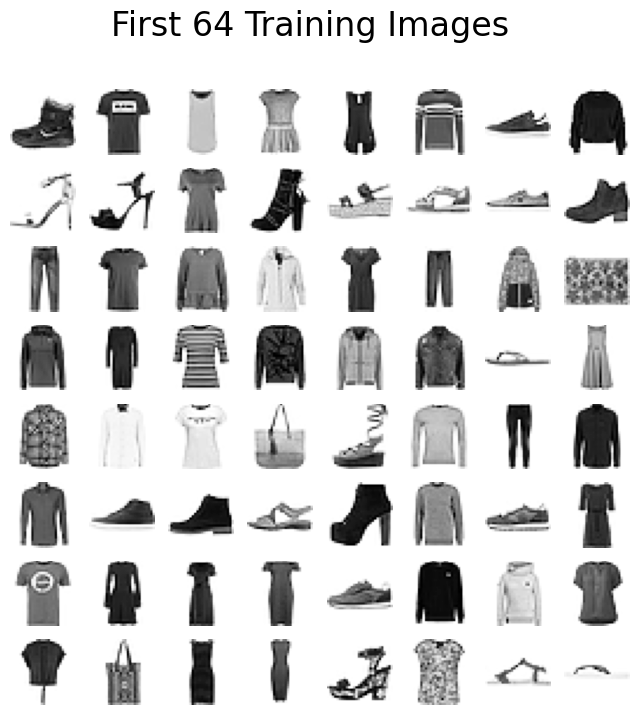

In [3]:
# Use the following code to load and normalize the dataset for training and testing
# It will downlad the dataset into data subfolder (change to your data folder name)
train_dataset = torchvision.datasets.FashionMNIST('data/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.FashionMNIST('data/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

# Convert to arrays for classifiers to apply
fashion_train_images = train_dataset.data.numpy().reshape(len(train_dataset), -1)  # (60000, 784)
fashion_test_images = test_dataset.data.numpy().reshape(len(test_dataset), -1)     # (10000, 784)

fashion_train_labels = train_dataset.targets.numpy()
fashion_test_labels = test_dataset.targets.numpy()

# Use the following code to create a validation set of 10%
train_indices, val_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.1,
)

# Generate training and validation subsets based on indices
train_split = Subset(train_dataset, train_indices)
val_split = Subset(train_dataset, val_indices)


# set batches sizes
train_batch_size = 512 #Define train batch size
test_batch_size  = 256 #Define test batch size (can be larger than train batch size)


# Define dataloader objects that help to iterate over batches and samples for
# training, validation and testing
train_batches = DataLoader(train_split, batch_size=train_batch_size, shuffle=True)
val_batches = DataLoader(val_split, batch_size=train_batch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=True)
                                           
num_train_batches=len(train_batches)
num_val_batches=len(val_batches)
num_test_batches=len(test_batches)


print(num_train_batches)
print(num_val_batches)
print(num_test_batches)


# Sample code to visulaize the first sample in first 16 batches 

# batch_num = 0
# for train_features, train_labels in train_batches:
    
#     if batch_num == 16:
#         break    # break here
    
#     batch_num = batch_num +1
#     print(f"Feature batch shape: {train_features.size()}")
#     print(f"Labels batch shape: {train_labels.size()}")
    
#     img = train_features[0].squeeze()
#     label = train_labels[0]
#     plt.imshow(img, cmap="gray")
#     plt.show()
#     print(f"Label: {label}")



# Sample code to plot N^2 images from the dataset
def plot_images(XX, N, title):
    fig, ax = plt.subplots(N, N, figsize=(8, 8))
    
    for i in range(N):
      for j in range(N):
        ax[i,j].imshow(XX[(N)*i+j], cmap="Greys")
        ax[i,j].axis("off")
    fig.suptitle(title, fontsize=24)

plot_images(train_dataset.data[:64], 8, "First 64 Training Images" )

### Define Fully Connected Neural Network (FCNs)

In [4]:
#Define your (As Cool As It Gets) Fully Connected Neural Network 
class ACAIGFCN(nn.Module):
    #Initialize model layers, add additional arguments to adjust
    def __init__(self, input_dim, output_dim, hidden_layers, dropout_rate=0, init_type=None, use_bn=False): 
        super(ACAIGFCN, self).__init__()
        self.use_bn = use_bn
        self.dropout = nn.Dropout(dropout_rate)
        #Define the network layer(s) and activation function(s)
        self.input_layer = nn.Linear(input_dim, hidden_layers[0])
        self.input_bn = nn.BatchNorm1d(hidden_layers[0]) if use_bn else None

        self.hidden_layers = nn.ModuleList()
        self.bn_layers = nn.ModuleList()
        for i in range(len(hidden_layers) - 1):
            self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
            if use_bn:
                self.bn_layers.append(nn.BatchNorm1d(hidden_layers[i + 1]))
        self.output_layer = nn.Linear(hidden_layers[-1], output_dim)
        self.initialize_weights(init_type)

    def initialize_weights(self, init_type):
        for layer in [self.input_layer] + list(self.hidden_layers) + [self.output_layer]:
            if isinstance(layer, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_normal_(layer.weight)
                elif init_type == 'kaiming':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                elif init_type == 'normal':
                    nn.init.normal_(layer.weight, mean=0, std=0.1)
                layer.bias.data.fill_(0.01)
 
    def forward(self, input):
        #Define how your model propagates the input through the network
        input = input.view(input.shape[0], -1)
        x = self.input_layer(input)
        if self.use_bn:
            x = self.input_bn(x)
        x = torch.nn.functional.relu(x)
        x = self.dropout(x)  # Apply dropout
        for i, layer in enumerate(self.hidden_layers):
            x = layer(x)
            if self.use_bn:
                x = self.bn_layers[i](x)
            x = torch.nn.functional.relu(x)
            x = self.dropout(x)  # Apply dropout

        output = self.output_layer(x)
        
        return output


### Define Convolutional Neural Network (CNNs)

In [5]:
# Define your (As Cool As It Gets) Convolutional Neural Network
class ACAIGCNN(nn.Module):
    def __init__(self, input_shape, conv_params, fc_hidden_layers, output_dim, dropout_rate=0.3):
        super(ACAIGCNN, self).__init__()

        self.dropout = nn.Dropout(dropout_rate)
        
        # Conv and pooling layers
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        in_channels = input_shape[0]
        for params in conv_params:
            conv = nn.Conv2d(
                in_channels=in_channels,  
                out_channels=params['out_channels'],
                kernel_size=params.get('kernel_size', 3),
                stride=params.get('stride', 1),
                padding=params.get('padding', 0))
            self.conv_layers.append(conv)
            in_channels = params['out_channels']                # Update channels after conv
            
            if 'pool_kernel' in params:                         # Add pooling layer if needed
                pool = nn.MaxPool2d(kernel_size=params['pool_kernel'], 
                                    stride=params.get('pool_stride', params['pool_kernel']))
            else:
                pool = None
            self.pool_layers.append(pool)

        with torch.no_grad():                                   # Compute feature map size
            dummy_input = torch.zeros(1, *input_shape)
            x = self.conv_forward(dummy_input)
            self.flattened_size = x.view(1, -1).shape[1]

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.fc_layers.append(nn.Linear(self.flattened_size, fc_hidden_layers[0]))
        for i in range(len(fc_hidden_layers) - 1):
            self.fc_layers.append(nn.Linear(fc_hidden_layers[i], fc_hidden_layers[i + 1]))
        self.fc_output = nn.Linear(fc_hidden_layers[-1], output_dim)

        self.initialize_weights()
    
    def conv_forward(self, x):
        for i, conv in enumerate(self.conv_layers):
            x = torch.nn.functional.relu(conv(x))
            if self.pool_layers[i] is not None:
                x = self.pool_layers[i](x)
            x = self.dropout(x)
        return x                                                # Output shape after conv
    
    def initialize_weights(self):
        for layer in self.conv_layers:
            nn.init.xavier_normal_(layer.weight)
            if layer.bias is not None:
                layer.bias.data.fill_(0.01)
        for layer in self.fc_layers:
            nn.init.xavier_normal_(layer.weight)
            layer.bias.data.fill_(0.01)
        nn.init.xavier_normal_(self.fc_output.weight)
        self.fc_output.bias.data.fill_(0.01)

    def forward(self, x):
        x = self.conv_forward(x)                                # Use conv_forward function
        x = x.view(x.size(0), -1)
        for fc in self.fc_layers:
            x = torch.nn.functional.relu(fc(x))
            x = self.dropout(x)
        x = self.fc_output(x)
        return x


### Functions for Computing Weights of FCN and CNN

In [6]:
def count_fcn_weights(input_dim=784, hidden_layers=[0], output_dim=10):
    total_weights = 0
    layer_sizes = [input_dim] + hidden_layers + [output_dim]

    for i in range(len(layer_sizes) - 1):
        total_weights += layer_sizes[i] * layer_sizes[i + 1]                # Weights
        total_weights += layer_sizes[i + 1]                                 # Biases

    return total_weights

def count_cnn_weights(conv_params, fc_hidden_layers, input_shape, output_dim):
    total_weights = 0
    in_channels = input_shape[0]
    feature_map_shape = list(input_shape[1:])

    # Count conv layer weights
    for conv in conv_params:
        kernel_size = conv['kernel_size']
        out_channels = conv['out_channels']
        stride = conv.get('stride', 1)
        padding = conv.get('padding', 0)
        
        total_weights += (in_channels * out_channels * (kernel_size ** 2))  # Conv weights
        total_weights += out_channels                                       # Biases

        # Feature map size after conv
        feature_map_shape[0] = (feature_map_shape[0] + 2 * padding - kernel_size) // stride + 1
        feature_map_shape[1] = (feature_map_shape[1] + 2 * padding - kernel_size) // stride + 1
        
        in_channels = out_channels

        if 'pool_kernel' in conv:                                           # Apply pooling
            pool_kernel = conv['pool_kernel']
            pool_stride = conv.get('pool_stride', pool_kernel)
            
            feature_map_shape[0] = (feature_map_shape[0] - pool_kernel) // pool_stride + 1
            feature_map_shape[1] = (feature_map_shape[1] - pool_kernel) // pool_stride + 1

    # Feature map size after conv & pool
    flattened_size = in_channels * feature_map_shape[0] * feature_map_shape[1]

    # Count FCN layer weights
    fc_layers = [flattened_size] + fc_hidden_layers + [output_dim]
    for i in range(len(fc_layers) - 1):
        total_weights += fc_layers[i] * fc_layers[i + 1]                    # Weights
        total_weights += fc_layers[i + 1]                                   # Biases

    return total_weights

### Function: Train and Evaluate FCN

In [7]:
def train_and_evaluate_FCN(train_batches, val_batches, test_batches, 
                           input_dim=784, output_dim=10, hidden_layers=[256, 128, 64], 
                           init_type=None, dropout_rate=0,
                           learning_rate=0.05, epochs=75, optimizer_type="SGD",
                           use_bn=False, track_val_loss=False):

    # Initialize model
    model = ACAIGFCN(input_dim=input_dim, output_dim=output_dim, 
                      hidden_layers=hidden_layers, dropout_rate=dropout_rate, 
                      init_type=init_type, use_bn=use_bn)
    
    loss_func = nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_type == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_type == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        print("Choose from 'SGD', 'RMSprop', or 'Adam'.")

    # Tracking loss and accuracy
    train_loss_list = np.zeros((epochs,))
    val_acc_list = np.zeros((epochs,))
    val_loss_list = np.zeros((epochs,)) if track_val_loss else None

    # Training loop
    for epoch in tqdm.trange(epochs):
        # ACAIGFCN Training 
        epoch_loss = 0.0
        for train_features, train_labels in train_batches:
            # Set model into training mode
            model.train()
            
            # Reshape images into a vector
            train_features = train_features.reshape(-1, 28*28)

            # Reset gradients, Calculate training loss on model 
            optimizer.zero_grad()
            outputs = model(train_features)
            loss = loss_func(outputs, train_labels)

            # Perfrom optimization, back propagation
            loss.backward()
            optimizer.step()
            
            # Accumulate the loss for the epoch
            epoch_loss += loss.item()

    
        # Record loss for the epoch
        train_loss_list[epoch] = epoch_loss / len(train_batches)
        # print('Epoch {}, loss {}'.format(epoch, loss.item()))

        # ACAIGFCN Validation
        correct_predictions = 0
        total_samples = 0
        val_loss = 0.0 if track_val_loss else None
        for val_features, val_labels in val_batches:
            
            # Telling PyTorch we aren't passing inputs to network for training purpose
            with torch.no_grad(): 
                model.eval()
                
                # Reshape validation images into a vector
                val_features = val_features.reshape(-1, 28*28)
            
                # Compute validation outputs (targets) and compute accuracy 
                validation_outputs = model(val_features)

            correct = (torch.argmax(validation_outputs, dim=1) == val_labels).float()
            
            # Accumulate correct predictions and total samples
            correct_predictions += correct.sum().item()
            total_samples += val_labels.size(0)

            if track_val_loss:
                val_loss += loss_func(validation_outputs, val_labels).item()

        # Compute and record validation accuracy
        val_acc_list[epoch] = correct_predictions / total_samples
                
        # Record accuracy for the epoch; print training loss, validation accuracy
        # print(f"Epoch: {epoch}; Validation Accuracy: {validation_accuracy_list[epoch] * 100:.2f}%")
        if track_val_loss:
            val_loss_list[epoch] = val_loss / len(val_batches)

    #Calculate accuracy on test set

    # Telling PyTorch we aren't passing inputs to network for training purpose
    with torch.no_grad():
        test_correct = 0
        total_test = 0
        batch_accs = []
        for test_features, test_labels in test_batches:

            model.eval()
            # Reshape test images into a vector
            test_features = test_features.reshape(-1, 28*28)

            # Compute validation outputs (targets) 
            test_outputs = model(test_features)
            correct1 = (torch.argmax(test_outputs, dim=1) == test_labels).float()
            batch_acc = correct1.mean().item()  # Accuracy for this batch
            batch_accs.append(batch_acc)
            
            # Accumulate correct predictions and total samples
            test_correct += correct1.sum().item()
            total_test += test_labels.size(0)
        
        # Compute total (mean) accuracy
        test_acc = test_correct / total_test
        test_acc_std = np.std(batch_accs)
        
        # Report total (mean) accuracy, can also compute std based on batches
        # print(f"Test Accuracy: {test_acc} ± {test_acc_std:.4f}")

    total_weights = count_fcn_weights(input_dim, hidden_layers, output_dim)
            
    if track_val_loss:
        return train_loss_list, val_acc_list, (test_acc, test_acc_std), val_loss_list, total_weights
    else:
        return train_loss_list, val_acc_list, (test_acc, test_acc_std), total_weights

### Function: Train and Evaluate CNN

In [8]:
def train_and_evaluate_CNN(train_batches, val_batches, test_batches,
                           input_shape=(1, 28, 28), output_dim=10,
                           conv_params=None, fc_hidden_layers=[128, 64], 
                           dropout_rate=0.5, learning_rate=0.05, 
                           epochs=75, optimizer_type="SGD",
                           track_val_loss=False):

    # Initialize model
    model = ACAIGCNN(input_shape=input_shape, conv_params=conv_params,
                      fc_hidden_layers=fc_hidden_layers, output_dim=output_dim,
                      dropout_rate=dropout_rate)

    loss_func = nn.CrossEntropyLoss()

    # Choose optimizer
    if optimizer_type == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    elif optimizer_type == "RMSprop":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)
    elif optimizer_type == "Adam":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        print("Choose from 'SGD', 'RMSprop', or 'Adam'.")

    # Tracking loss and accuracy
    train_loss_list = np.zeros((epochs,))
    val_acc_list = np.zeros((epochs,))
    val_loss_list = np.zeros((epochs,)) if track_val_loss else None

    # Training loop
    for epoch in tqdm.trange(epochs):
        model.train()
        epoch_loss = 0.0
        
        for train_features, train_labels in train_batches:
            optimizer.zero_grad()
            outputs = model(train_features)
            loss = loss_func(outputs, train_labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_loss_list[epoch] = epoch_loss / len(train_batches)

        # Validation
        correct_predictions = 0
        total_samples = 0
        val_loss = 0.0 if track_val_loss else None
        
        with torch.no_grad():
            model.eval()
            for val_features, val_labels in val_batches:
                validation_outputs = model(val_features)
                correct = (torch.argmax(validation_outputs, dim=1) == val_labels).float()
                correct_predictions += correct.sum().item()
                total_samples += val_labels.size(0)

                if track_val_loss:
                    val_loss += loss_func(validation_outputs, val_labels).item()

        val_acc_list[epoch] = correct_predictions / total_samples

        if track_val_loss:
            val_loss_list[epoch] = val_loss / len(val_batches)

    # Testing
    with torch.no_grad():
        test_correct = 0
        total_test = 0
        batch_accs = []
        for test_features, test_labels in test_batches:
            model.eval()
            test_outputs = model(test_features)
            correct = (torch.argmax(test_outputs, dim=1) == test_labels).float()

            batch_acc = correct.mean().item()  # Accuracy for this batch
            batch_accs.append(batch_acc)

            test_correct += correct.sum().item()
            total_test += test_labels.size(0)
        
        test_acc = test_correct / total_test
        test_acc_std = np.std(batch_accs)

    # Count weights
    total_weights = count_cnn_weights(conv_params, fc_hidden_layers, input_shape, output_dim)

    if track_val_loss:
        return train_loss_list, val_acc_list, (test_acc, test_acc_std), val_loss_list, total_weights
    else:
        return train_loss_list, val_acc_list, (test_acc, test_acc_std), total_weights

### Compute FCN and CNN Weights with Different Parameters

In [13]:
# compute FCN weights
input_dim = 784
hidden_layers = [115, 75]
output_dim = 10
total_params = count_fcn_weights(input_dim, hidden_layers, output_dim)
print(f"Total weights in FCN: {total_params}")

Total weights in FCN: 99735


In [13]:
# compute CNN weights
conv_params_test = [
    {'in_channels': 1, 'out_channels': 16, 'kernel_size': 2, 'pool_kernel': 2, 'pool_stride': 2},  
    {'in_channels': 16, 'out_channels': 32, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hidden_layers_test = [110, 55]
input_shape = (1, 28, 28)
output_dim = 10


total_weights = count_cnn_weights(conv_params_test, fc_hidden_layers_test, input_shape, output_dim)
print(f"Total weights in CNN: {total_weights}")

Total weights in CNN: 99495


## Task 1: FCN 100K Model

### Test Accuracy > 88%

In [14]:
# FCN 100K
train_loss_fcn100K, val_acc_fcn100K, test_info_fcn100K, val_loss_fcn100K, weights_fcn100K = train_and_evaluate_FCN(
    train_batches, val_batches, test_batches, hidden_layers=[115, 75], 
    init_type='xavier', optimizer_type="Adam", dropout_rate=0.3,
    learning_rate=0.001, epochs=35, track_val_loss=True)
test_acc_fcn100K, test_std_fcn100K = test_info_fcn100K

print(f"FCN 100K \nWeights: {weights_fcn100K}, Test Accuracy: {test_acc_fcn100K:.4f} ± {test_std_fcn100K:.4f}")

100%|██████████| 35/35 [01:45<00:00,  3.02s/it]


FCN 100K 
Weights: 99735, Test Accuracy: 0.8869 ± 0.0203


## Task 2: FCN 50K Model & FCN 200K Model

In [ ]:
# FCN 50K
train_loss_fcn50K, val_acc_fcn50K, test_info_fcn50K, weights_fcn50K = train_and_evaluate_FCN(
    train_batches, val_batches, test_batches, hidden_layers=[60, 30], 
    init_type='xavier', optimizer_type="Adam", dropout_rate=0.3,
    learning_rate=0.001, epochs=35)
test_acc_fcn50K, test_std_fcn50K = test_info_fcn50K

# FCN 200K
train_loss_fcn200K, val_acc_fcn200K, test_info_fcn200K, weights_fcn200K = train_and_evaluate_FCN(
    train_batches, val_batches, test_batches, hidden_layers=[220, 110], 
    init_type='xavier', optimizer_type="Adam", dropout_rate=0.3,
    learning_rate=0.001, epochs=35)
test_acc_fcn200K, test_std_fcn200K = test_info_fcn200K

print(f"FCN 50K \nWeights: {weights_fcn50K}, Test Accuracy: {test_acc_fcn50K:.4f} ± {test_std_fcn50K:.4f}")
print(f"FCN 200K \nWeights: {weights_fcn200K}, Test Accuracy: {test_acc_fcn200K:.4f} ± {test_std_fcn200K:.4f}")

100%|██████████| 35/35 [01:49<00:00,  3.12s/it]


FCN 50K 
Weights: 49240, Test Accuracy: 0.8751 ± 0.0224
FCN 200K 
Weights: 198120, Test Accuracy: 0.8915 ± 0.0214


### Plot Training Loss and Validation Accuracy for FCN 50K, 100K, 200K Models

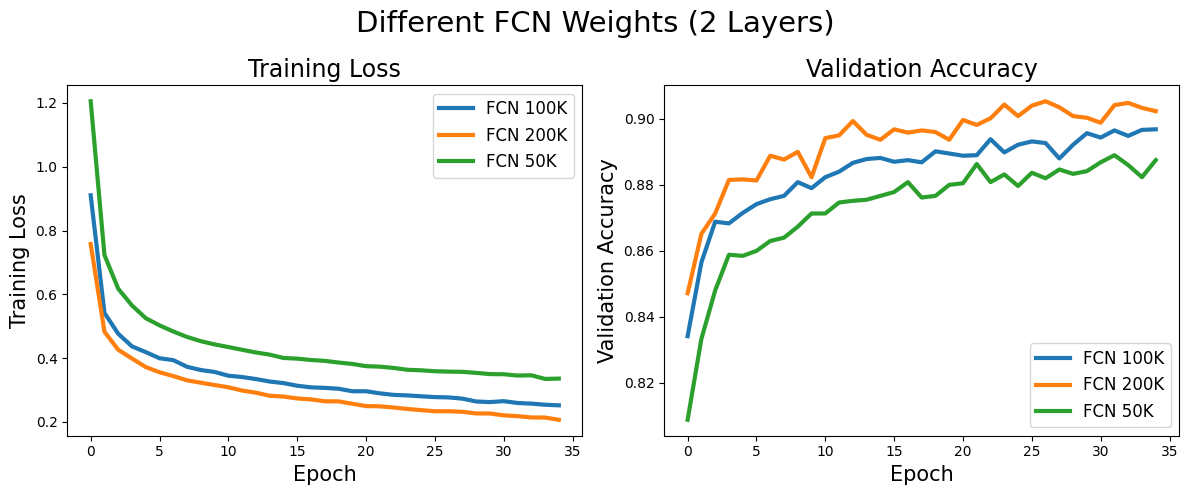

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_fcn100K, linewidth=3, label="FCN 100K")
plt.plot(train_loss_fcn200K, linewidth=3, label="FCN 200K")
plt.plot(train_loss_fcn50K, linewidth=3, label="FCN 50K")
plt.xlabel("Epoch", fontdict=dict(size=15))
plt.ylabel("Training Loss", fontdict=dict(size=15))
plt.title("Training Loss", fontdict=dict(size=17))
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(val_acc_fcn100K, linewidth=3, label="FCN 100K")
plt.plot(val_acc_fcn200K, linewidth=3, label="FCN 200K")
plt.plot(val_acc_fcn50K, linewidth=3, label="FCN 50K")
plt.xlabel("Epoch", fontdict=dict(size=15))
plt.ylabel("Validation Accuracy", fontdict=dict(size=15))
plt.title("Validation Accuracy", fontdict=dict(size=17))
plt.legend(fontsize=12)
plt.suptitle("Different FCN Weights (2 Layers)", fontsize=21)
plt.tight_layout()
plt.savefig('Different FCN Weights 2 Layers.pdf')
plt.show()

## Task 3: CNN 100K Model (2 Conv Layers)

In [ ]:
# CNN 100K 2C
conv_params_100K = [
    {'in_channels': 1, 'out_channels': 16, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2},  
    {'in_channels': 16, 'out_channels': 32, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hl_100K = [110, 55]

train_loss_cnn100K, val_acc_cnn100K, test_info_cnn100K, val_loss_cnn100K, weights_cnn100K = train_and_evaluate_CNN(
    train_batches, val_batches, test_batches,
    input_shape=(1, 28, 28), output_dim=10,
    conv_params=conv_params_100K, fc_hidden_layers=fc_hl_100K,
    dropout_rate=0.3, learning_rate=0.001, epochs=35,
    optimizer_type="Adam", track_val_loss=True)
test_acc_cnn100K, test_std_cnn100K = test_info_cnn100K


print(f"CNN 100K - 2 Conv layers")
print(f"Weights: {weights_cnn100K}, Test Accuracy: {test_acc_cnn100K:.4f} ± {test_std_cnn100K:.4f}")

100%|██████████| 35/35 [05:45<00:00,  9.86s/it]


CNN 100K - 2 Conv layers
Weights: 99575, Test Accuracy: 0.9054 ± 0.0176


## Task 4.1: CNN 50K Model (2 Conv Layers)

In [ ]:
# CNN 50K 2C
conv_params_50K = [
    {'in_channels': 1, 'out_channels': 12, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2},  
    {'in_channels': 12, 'out_channels': 24, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hl_50K = [70, 60]

train_loss_cnn50K, val_acc_cnn50K, test_info_cnn50K, weights_cnn50K = train_and_evaluate_CNN(
    train_batches, val_batches, test_batches,
    input_shape=(1, 28, 28), output_dim=10,
    conv_params=conv_params_50K, fc_hidden_layers=fc_hl_50K,
    dropout_rate=0.3, learning_rate=0.001, epochs=35,
    optimizer_type="Adam")
test_acc_cnn50K, test_std_cnn50K = test_info_cnn50K

print(f"CNN 50K - 2 Conv layers")
print(f"Weights: {weights_cnn50K}, Test Accuracy: {test_acc_cnn50K:.4f} ± {test_std_cnn50K:.4f}")

100%|██████████| 35/35 [05:01<00:00,  8.62s/it]


CNN 50K - 2 Conv layers
Weights: 49676, Test Accuracy: 0.8955 ± 0.0194


## Task 4.2: CNN 20K Model (2 Conv Layers)

In [ ]:
# CNN 20K 2C
conv_params_20K = [
    {'in_channels': 1, 'out_channels': 12, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2},
    {'in_channels': 12, 'out_channels': 24, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hl_20K = [25, 60]

train_loss_cnn20K, val_acc_cnn20K, test_info_cnn20K, weights_cnn20K = train_and_evaluate_CNN(
    train_batches, val_batches, test_batches,
    input_shape=(1, 28, 28), output_dim=10,
    conv_params=conv_params_20K, fc_hidden_layers=fc_hl_20K,
    dropout_rate=0.3, learning_rate=0.001, epochs=35,
    optimizer_type="Adam")
test_acc_cnn20K, test_std_cnn20K = test_info_cnn20K

print(f"CNN 20K - 2 Conv layers")
print(f"Weights: {weights_cnn20K}, Test Accuracy: {test_acc_cnn20K:.4f} ± {test_std_cnn20K:.4f}")

100%|██████████| 35/35 [05:00<00:00,  8.59s/it]


CNN 20K - 2 Conv layers
Weights: 19931, Test Accuracy: 0.8792 ± 0.0222


## Task 4.3: CNN 10K Model (2 Conv Layers)

In [ ]:
# CNN 10K 2C
conv_params_10K = [
    {'in_channels': 1, 'out_channels': 11, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2},  
    {'in_channels': 11, 'out_channels': 22, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hl_10K = [13, 20]

train_loss_cnn10K, val_acc_cnn10K, test_info_cnn10K, weights_cnn10K = train_and_evaluate_CNN(
    train_batches, val_batches, test_batches,
    input_shape=(1, 28, 28), output_dim=10,
    conv_params=conv_params_10K, fc_hidden_layers=fc_hl_10K,
    dropout_rate=0.3, learning_rate=0.001, epochs=35,
    optimizer_type="Adam")
test_acc_cnn10K, test_std_cnn10K = test_info_cnn10K

print(f"CNN 10K - 2 Conv layers")
print(f"Weights: {weights_cnn10K}, Test Accuracy: {test_acc_cnn10K:.4f} ± {test_std_cnn10K:.4f}")

100%|██████████| 35/35 [04:50<00:00,  8.31s/it]


CNN 10K - 2 Conv layers
Weights: 9963, Test Accuracy: 0.8294 ± 0.0266


### Plot Training Loss and Validation Accuracy for CNN 100K, 50K, 20K, 10K Models (2 Conv Layers)

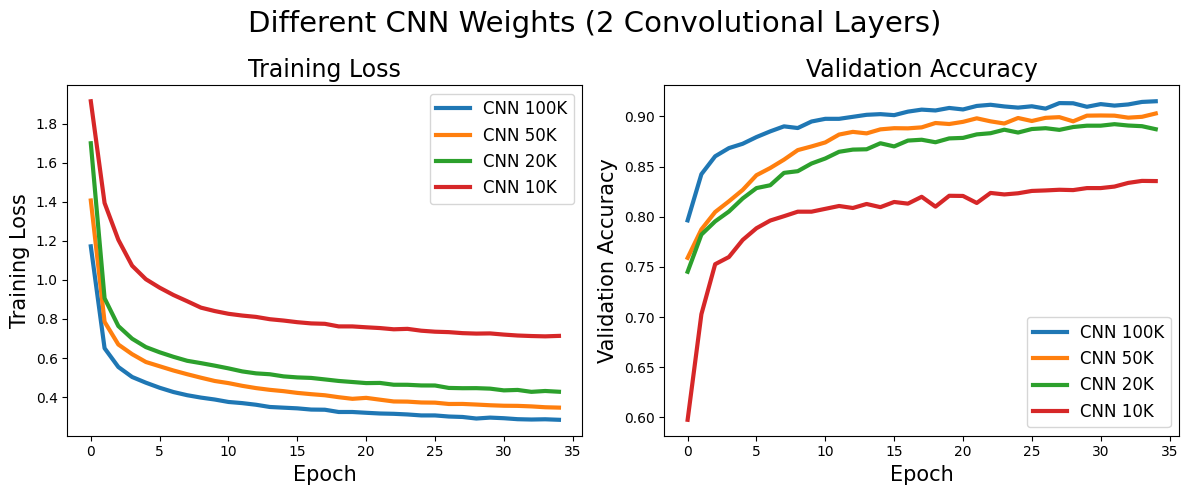

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_cnn100K, linewidth=3, label="CNN 100K")
plt.plot(train_loss_cnn50K, linewidth=3, label="CNN 50K")
plt.plot(train_loss_cnn20K, linewidth=3, label="CNN 20K")
plt.plot(train_loss_cnn10K, linewidth=3, label="CNN 10K")
plt.xlabel("Epoch", fontdict=dict(size=15))
plt.ylabel("Training Loss", fontdict=dict(size=15))
plt.title("Training Loss", fontdict=dict(size=17))
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(val_acc_cnn100K, linewidth=3, label="CNN 100K")
plt.plot(val_acc_cnn50K, linewidth=3, label="CNN 50K")
plt.plot(val_acc_cnn20K, linewidth=3, label="CNN 20K")
plt.plot(val_acc_cnn10K, linewidth=3, label="CNN 10K")
plt.xlabel("Epoch", fontdict=dict(size=15))
plt.ylabel("Validation Accuracy", fontdict=dict(size=15))
plt.title("Validation Accuracy", fontdict=dict(size=17))
plt.legend(fontsize=12)
plt.suptitle("Different CNN Weights (2 Convolutional Layers)", fontsize=21)
plt.tight_layout()
plt.savefig('Different CNN Weights 2C.pdf')
plt.show()

### Plot Training, Validation Loss and Validation Accuracy for CNN 100K & FCN 100K Models

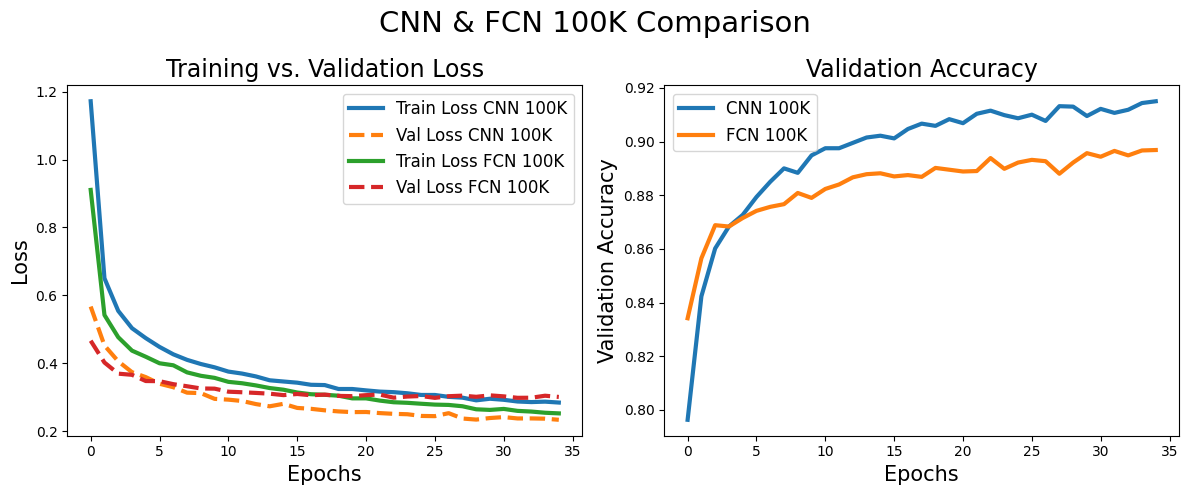

In [ ]:
plt.figure(figsize=(12, 5))
# Training Loss & Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_cnn100K, linewidth=3, linestyle="-", label=f"Train Loss CNN 100K")
plt.plot(val_loss_cnn100K, linewidth=3, linestyle="--", label=f"Val Loss CNN 100K")
plt.plot(train_loss_fcn100K, linewidth=3, linestyle="-", label=f"Train Loss FCN 100K")
plt.plot(val_loss_fcn100K, linewidth=3, linestyle="--", label=f"Val Loss FCN 100K")
plt.xlabel("Epochs", fontdict=dict(size=15))
plt.ylabel("Loss", fontdict=dict(size=15))
plt.title("Training vs. Validation Loss", fontdict=dict(size=17))
plt.legend(fontsize=12)
# Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(val_acc_cnn100K, linewidth=3, label=f"CNN 100K")
plt.plot(val_acc_fcn100K, linewidth=3, label=f"FCN 100K")
plt.xlabel("Epochs", fontdict=dict(size=15))
plt.ylabel("Validation Accuracy", fontdict=dict(size=15))
plt.title("Validation Accuracy", fontdict=dict(size=17))
plt.legend(fontsize=12)
plt.suptitle("CNN & FCN 100K Comparison", fontsize=21)
plt.tight_layout()
plt.savefig('CNN & FCN 100K Comparison.pdf')
plt.show()

## Task 3: CNN 100K Model (3 Conv Layers)

In [ ]:
conv_params_100K3C = [
    {'in_channels': 1, 'out_channels': 16, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2},  
    {'in_channels': 16, 'out_channels': 32, 'kernel_size': 3},
    {'in_channels': 32, 'out_channels': 64, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hl_100K3C = [60, 120, 60]

train_loss_cnn100K3C, val_acc_cnn100K3C, test_info_cnn100K3C, weights_cnn100K3C = train_and_evaluate_CNN(
    train_batches, val_batches, test_batches,
    input_shape=(1, 28, 28), output_dim=10,
    conv_params=conv_params_100K3C, fc_hidden_layers=fc_hl_100K3C,
    dropout_rate=0.3, learning_rate=0.001, epochs=35,
    optimizer_type="Adam")
test_acc_cnn100K3C, test_std_cnn100K3C = test_info_cnn100K3C

print(f"CNN 100K - 3 Conv layers")
print(f"Weights: {weights_cnn100K3C}, Test Accuracy: {test_acc_cnn100K3C:.4f} ± {test_std_cnn100K3C:.4f}")

100%|██████████| 35/35 [09:23<00:00, 16.10s/it]


CNN 100K - 3 Conv layers
Weights: 99986, Test Accuracy: 0.9083 ± 0.0173


## Task 4.1: CNN 50K Model (3 Conv Layers)

In [ ]:
conv_params_50K3C = [
    {'in_channels': 1, 'out_channels': 12, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2},  
    {'in_channels': 12, 'out_channels': 24, 'kernel_size': 3},
    {'in_channels': 24, 'out_channels': 48, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hl_50K3C = [46, 24]

train_loss_cnn50K3C, val_acc_cnn50K3C, test_info_cnn50K3C, weights_cnn50K3C = train_and_evaluate_CNN(
    train_batches, val_batches, test_batches,
    input_shape=(1, 28, 28), output_dim=10,
    conv_params=conv_params_50K3C, fc_hidden_layers=fc_hl_50K3C,
    dropout_rate=0.3, learning_rate=0.001, epochs=35,
    optimizer_type="Adam")
test_acc_cnn50K3C, test_std_cnn50K3C = test_info_cnn50K3C

print("CNN 50K - 3 Conv layers")
print(f"Weights: {weights_cnn50K3C}, Test Accuracy: {test_acc_cnn50K3C:.4f} ± {test_std_cnn50K3C:.4f}")

100%|██████████| 35/35 [07:58<00:00, 13.68s/it]


CNN 50K - 3 Conv layers
Weights: 49904, Test Accuracy: 0.8893 ± 0.0194


## Task 4.2: CNN 20K Model (3 Conv Layers)

In [ ]:
conv_params_20K3C = [
    {'in_channels': 1, 'out_channels': 10, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2},  
    {'in_channels': 10, 'out_channels': 20, 'kernel_size': 3},
    {'in_channels': 20, 'out_channels': 40, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hl_20K3C = [15, 30, 15]

train_loss_cnn20K3C, val_acc_cnn20K3C, test_info_cnn20K3C, weights_cnn20K3C = train_and_evaluate_CNN(
    train_batches, val_batches, test_batches,
    input_shape=(1, 28, 28), output_dim=10,
    conv_params=conv_params_20K3C, fc_hidden_layers=fc_hl_20K3C,
    dropout_rate=0.3, learning_rate=0.001, epochs=35,
    optimizer_type="Adam")
test_acc_cnn20K3C, test_std_cnn20K3C = test_info_cnn20K3C

print("CNN 20K - 3 Conv layers")
print(f"Weights: {weights_cnn20K3C}, Test Accuracy: {test_acc_cnn20K3C:.4f} ± {test_std_cnn20K3C:.4f}")

100%|██████████| 35/35 [07:06<00:00, 12.19s/it]


CNN 20K - 3 Conv layers
Weights: 19880, Test Accuracy: 0.8107 ± 0.0240


## Task 4.3: CNN 10K Model (3 Conv Layers)

In [ ]:
conv_params_10K3C = [
    {'in_channels': 1, 'out_channels': 7, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2},  
    {'in_channels': 7, 'out_channels': 14, 'kernel_size': 3},
    {'in_channels': 14, 'out_channels': 28, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
]
fc_hl_10K3C = [10, 36, 12]

train_loss_cnn10K3C, val_acc_cnn10K3C, test_info_cnn10K3C, weights_cnn10K3C = train_and_evaluate_CNN(
    train_batches, val_batches, test_batches,
    input_shape=(1, 28, 28), output_dim=10,
    conv_params=conv_params_10K3C, fc_hidden_layers=fc_hl_10K3C,
    dropout_rate=0.3, learning_rate=0.001, epochs=35,
    optimizer_type="Adam")
test_acc_cnn10K3C, test_std_cnn10K3C = test_info_cnn10K3C

print("CNN 10K - 3 Conv layers")
print(f"Weights: {weights_cnn10K3C}, Test Accuracy: {test_acc_cnn10K3C:.4f} ± {test_std_cnn10K3C:.4f}")

100%|██████████| 35/35 [05:51<00:00, 10.04s/it]


CNN 10K - 3 Conv layers
Weights: 9982, Test Accuracy: 0.7430 ± 0.0285


### Plot Training Loss and Validation Accuracy for CNN 100K, 50K, 20K, 10K Models (3 Conv Layers)

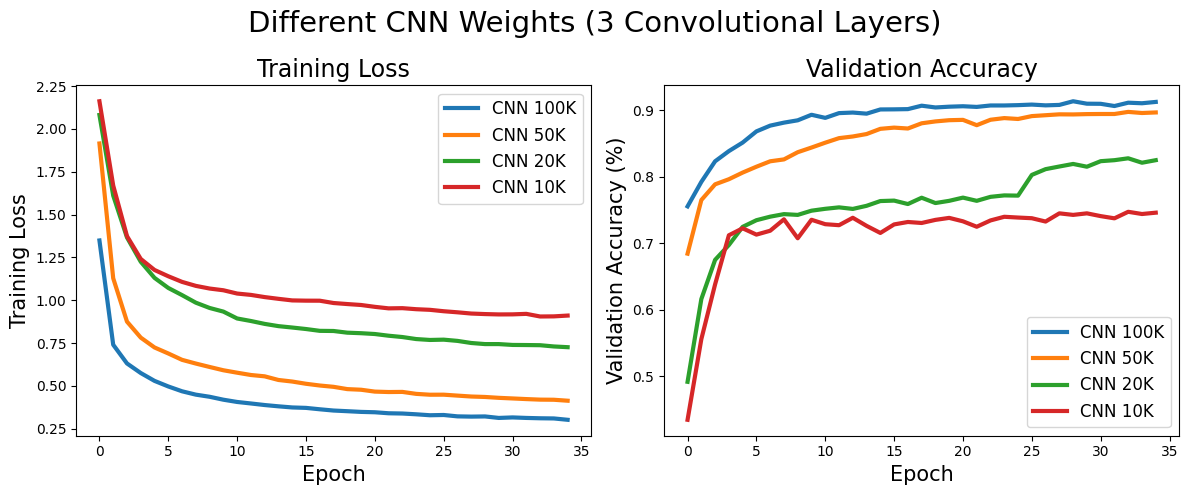

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_cnn100K3C, linewidth=3, label="CNN 100K")
plt.plot(train_loss_cnn50K3C, linewidth=3, label="CNN 50K")
plt.plot(train_loss_cnn20K3C, linewidth=3, label="CNN 20K")
plt.plot(train_loss_cnn10K3C, linewidth=3, label="CNN 10K")
plt.xlabel("Epoch", fontdict=dict(size=15))
plt.ylabel("Training Loss", fontdict=dict(size=15))
plt.title("Training Loss", fontdict=dict(size=17))
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(val_acc_cnn100K3C, linewidth=3, label="CNN 100K")
plt.plot(val_acc_cnn50K3C, linewidth=3, label="CNN 50K")
plt.plot(val_acc_cnn20K3C, linewidth=3, label="CNN 20K")
plt.plot(val_acc_cnn10K3C, linewidth=3, label="CNN 10K")
plt.xlabel("Epoch", fontdict=dict(size=15))
plt.ylabel("Validation Accuracy (%)", fontdict=dict(size=15))
plt.title("Validation Accuracy", fontdict=dict(size=17))
plt.legend(fontsize=12)
plt.suptitle("Different CNN Weights (3 Convolutional Layers)", fontsize=21)
plt.tight_layout()
plt.savefig('Different CNN Weights (3 Convolutional Layers).pdf')
plt.show()

### Plot Training Loss and Validation Accuracy for CNN 100K, 50K, 20K, 10K Models (2 & 3 Conv Layers)

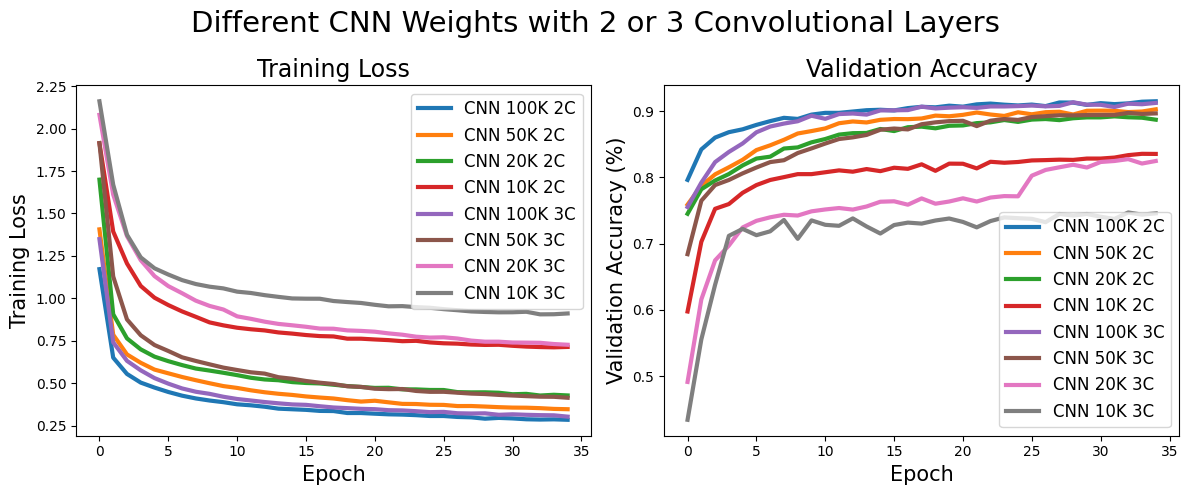

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_cnn100K, linewidth=3, label="CNN 100K 2C")
plt.plot(train_loss_cnn50K, linewidth=3, label="CNN 50K 2C")
plt.plot(train_loss_cnn20K, linewidth=3, label="CNN 20K 2C")
plt.plot(train_loss_cnn10K, linewidth=3, label="CNN 10K 2C")
plt.plot(train_loss_cnn100K3C, linewidth=3, label="CNN 100K 3C")
plt.plot(train_loss_cnn50K3C, linewidth=3, label="CNN 50K 3C")
plt.plot(train_loss_cnn20K3C, linewidth=3, label="CNN 20K 3C")
plt.plot(train_loss_cnn10K3C, linewidth=3, label="CNN 10K 3C")
plt.xlabel("Epoch", fontdict=dict(size=15))
plt.ylabel("Training Loss", fontdict=dict(size=15))
plt.title("Training Loss", fontdict=dict(size=17))
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(val_acc_cnn100K, linewidth=3, label="CNN 100K 2C")
plt.plot(val_acc_cnn50K, linewidth=3, label="CNN 50K 2C")
plt.plot(val_acc_cnn20K, linewidth=3, label="CNN 20K 2C")
plt.plot(val_acc_cnn10K, linewidth=3, label="CNN 10K 2C")
plt.plot(val_acc_cnn100K3C, linewidth=3, label="CNN 100K 3C")
plt.plot(val_acc_cnn50K3C, linewidth=3, label="CNN 50K 3C")
plt.plot(val_acc_cnn20K3C, linewidth=3, label="CNN 20K 3C")
plt.plot(val_acc_cnn10K3C, linewidth=3, label="CNN 10K 3C")
plt.xlabel("Epoch", fontdict=dict(size=15))
plt.ylabel("Validation Accuracy (%)", fontdict=dict(size=15))
plt.title("Validation Accuracy", fontdict=dict(size=17))
plt.legend(fontsize=12)
plt.suptitle("Different CNN Weights with 2 or 3 Convolutional Layers", fontsize=21)
plt.tight_layout()
plt.savefig('Different CNN Weights Comparison.pdf')
plt.show()

### --------------------- (Test) Different Conv Kernel Sizes of CNN 100K -------------------------

In [ ]:
# # CNN 100K 
# conv_params_2K2K = [
#     {'in_channels': 1, 'out_channels': 16, 'kernel_size': 2, 'pool_kernel': 2, 'pool_stride': 2},  
#     {'in_channels': 16, 'out_channels': 32, 'kernel_size': 2, 'pool_kernel': 2, 'pool_stride': 2}
# ]
# fc_hl_2K2K = [80, 60]

# train_loss_cnn2K2K, val_acc_cnn2K2K, test_info_cnn2K2K, weights_cnn2K2K = train_and_evaluate_CNN(
#     train_batches, val_batches, test_batches,
#     input_shape=(1, 28, 28), output_dim=10,
#     conv_params=conv_params_2K2K, fc_hidden_layers=fc_hl_2K2K,
#     dropout_rate=0.3, learning_rate=0.001, epochs=35,
#     optimizer_type="Adam")
# test_acc_cnn2K2K, test_std_cnn2K2K = test_info_cnn2K2K

# print("CNN 100K - Kernel Size 2 + 2")
# print(f"Weights: {weights_cnn2K2K}, Test Accuracy: {test_acc_cnn2K2K:.4f} ± {test_std_cnn2K2K:.4f}")

100%|██████████| 35/35 [05:50<00:00, 10.00s/it]


CNN 100K - Kernel Size 2 + 2
Weights: 99870, Test Accuracy: 0.8988 ± 0.0233


In [ ]:
# #CNN 100K
# conv_params_4K4K = [
#     {'in_channels': 1, 'out_channels': 16, 'kernel_size': 4, 'pool_kernel': 2, 'pool_stride': 2},  
#     {'in_channels': 16, 'out_channels': 32, 'kernel_size': 4, 'pool_kernel': 2, 'pool_stride': 2}
# ]
# fc_hl_4K4K = [150, 90]

# train_loss_cnn4K4K, val_acc_cnn4K4K, test_info_cnn4K4K, weights_cnn4K4K = train_and_evaluate_CNN(
#     train_batches, val_batches, test_batches,
#     input_shape=(1, 28, 28), output_dim=10,
#     conv_params=conv_params_4K4K, fc_hidden_layers=fc_hl_4K4K,
#     dropout_rate=0.3, learning_rate=0.001, epochs=35,
#     optimizer_type="Adam")
# test_acc_cnn4K4K, test_std_cnn4K4K = test_info_cnn4K4K

# print("CNN 100K - Kernel Size 4 + 4")
# print(f"Weights: {weights_cnn4K4K}, Test Accuracy: {test_acc_cnn4K4K:.4f} ± {test_std_cnn4K4K:.4f}")

100%|██████████| 35/35 [06:00<00:00, 10.30s/it]


CNN 100K - Kernel Size 4 + 4
Weights: 99946, Test Accuracy: 0.8992 ± 0.0200


In [ ]:
# # CNN 100K
# conv_params_2K3K = [
#     {'in_channels': 1, 'out_channels': 16, 'kernel_size': 2, 'pool_kernel': 2, 'pool_stride': 2},  
#     {'in_channels': 16, 'out_channels': 32, 'kernel_size': 3, 'pool_kernel': 2, 'pool_stride': 2}
# ]
# fc_hl_2K3K = [110, 55]

# train_loss_cnn2K3K, val_acc_cnn2K3K, test_info_cnn2K3K, weights_cnn2K3K = train_and_evaluate_CNN(
#     train_batches, val_batches, test_batches,
#     input_shape=(1, 28, 28), output_dim=10,
#     conv_params=conv_params_2K3K, fc_hidden_layers=fc_hl_2K3K,
#     dropout_rate=0.3, learning_rate=0.001, epochs=35,
#     optimizer_type="Adam")
# test_acc_cnn2K3K, test_std_cnn2K3K = test_info_cnn2K3K

# print("CNN 100K - Kernel Size 2 + 3")
# print(f"Weights: {weights_cnn2K3K}, Test Accuracy: {test_acc_cnn2K3K:.4f} ± {test_std_cnn2K3K:.4f}")

100%|██████████| 35/35 [06:20<00:00, 10.87s/it]


CNN 100K - Kernel Size 2 + 3
Weights: 99495, Test Accuracy: 0.9000 ± 0.0205


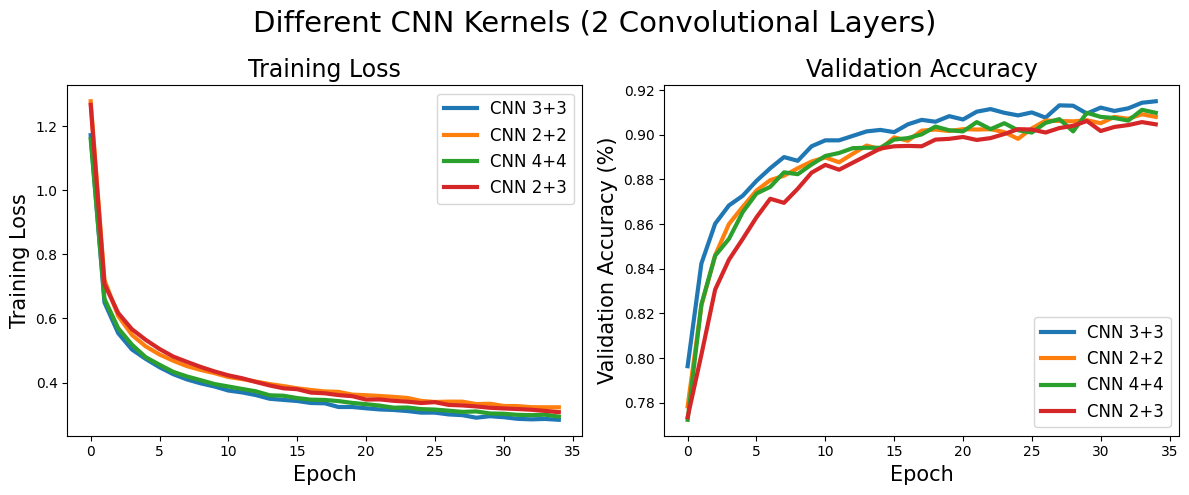

In [ ]:
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_loss_cnn100K, linewidth=3, label="CNN 3+3")
# plt.plot(train_loss_cnn2K2K, linewidth=3, label="CNN 2+2")
# plt.plot(train_loss_cnn4K4K, linewidth=3, label="CNN 4+4")
# plt.plot(train_loss_cnn2K3K, linewidth=3, label="CNN 2+3")
# plt.xlabel("Epoch", fontdict=dict(size=15))
# plt.ylabel("Training Loss", fontdict=dict(size=15))
# plt.title("Training Loss", fontdict=dict(size=17))
# plt.legend(fontsize=12)

# plt.subplot(1, 2, 2)
# plt.plot(val_acc_cnn100K, linewidth=3, label="CNN 3+3")
# plt.plot(val_acc_cnn2K2K, linewidth=3, label="CNN 2+2")
# plt.plot(val_acc_cnn4K4K, linewidth=3, label="CNN 4+4")
# plt.plot(val_acc_cnn2K3K, linewidth=3, label="CNN 2+3")
# plt.xlabel("Epoch", fontdict=dict(size=15))
# plt.ylabel("Validation Accuracy (%)", fontdict=dict(size=15))
# plt.title("Validation Accuracy", fontdict=dict(size=17))
# plt.legend(fontsize=12)
# plt.suptitle("Different CNN Kernels (2 Convolutional Layers)", fontsize=21)
# plt.tight_layout()
# plt.savefig('Different CNN Kernels (2 Convolutional Layers).pdf')
# plt.show()

## Task 5: Feature Maps Visualization of CNN 100K Model (2 & 3 Conv Layers)

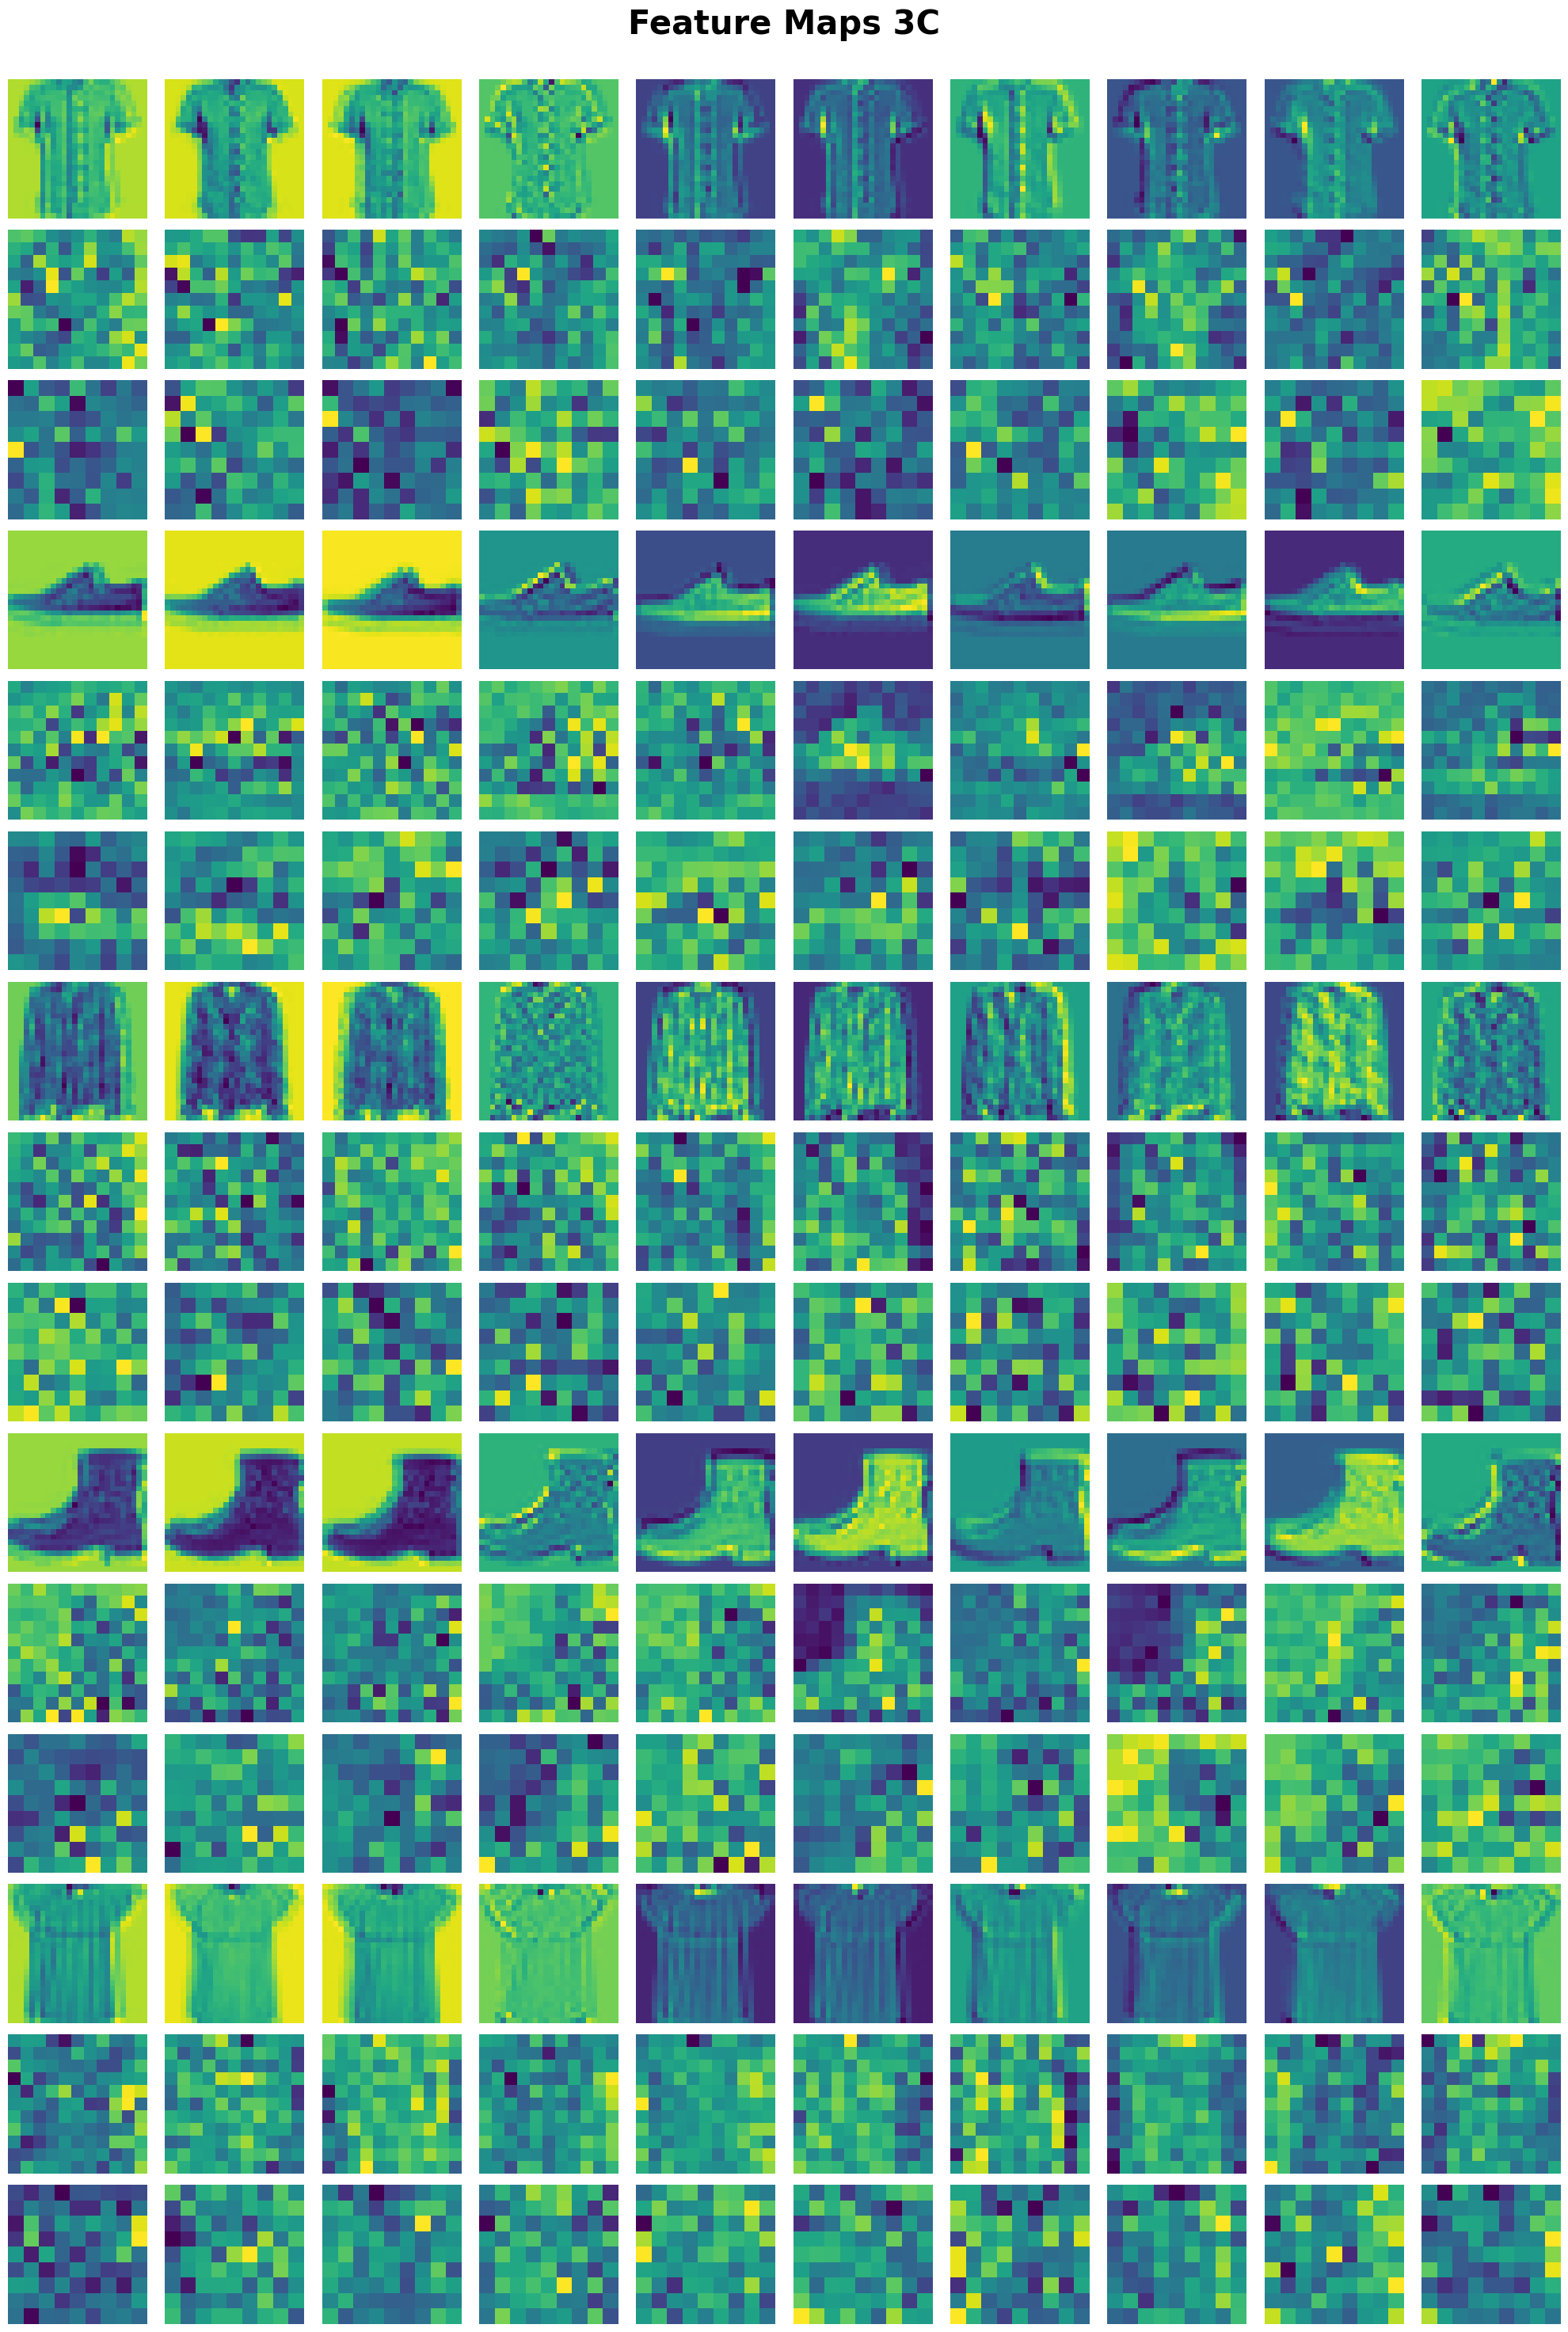

In [ ]:

model_100K2C = ACAIGCNN(input_shape=(1, 28, 28), conv_params=conv_params_100K, 
    fc_hidden_layers=fc_hl_100K, output_dim=10, dropout_rate=0.3)
model_100K3C = ACAIGCNN(input_shape=(1, 28, 28), conv_params=conv_params_100K3C, 
    fc_hidden_layers=fc_hl_100K3C, output_dim=10, dropout_rate=0.3)

def get_fm(model, sample_inputs):
    # Extract feature maps from conv layers
    feature_maps = []
    hooks = []

    def hook_fn(module, input, output):
        feature_maps.append(output.detach())

    for layer in model.conv_layers:
        hooks.append(layer.register_forward_hook(hook_fn))

    with torch.no_grad():                                   # Forward pass on sample inputs
        _ = model(sample_inputs)

    for hook in hooks:
        hook.remove()

    return feature_maps                                     # List of feature maps

def visualize(feature_maps, num_samples=5, num_maps=8):
    # Visualize feature maps from different classes
    num_layers = len(feature_maps)
    
    _, axes = plt.subplots(num_samples * num_layers, num_maps, figsize=(num_maps * 2, num_samples * num_layers * 2))

    for sample in range(num_samples):                       # iterate over samples
        for layer, fmap in enumerate(feature_maps):         # iterate over layers
            fmap_sample = fmap[sample]                      # Select feature map
            num_features = fmap_sample.shape[0]

            for i in range(min(num_maps, num_features)):    # num of maps each row
                ax = axes[sample * num_layers + layer, i]
                ax.imshow(fmap_sample[i].cpu().numpy(), cmap="viridis")
                ax.axis("off")
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)                           # save space for suptitle                   
    plt.suptitle("Feature Maps 3C", fontsize=30, fontweight="bold")

    plt.savefig("Feature Maps 3C.pdf", bbox_inches="tight")
    plt.show()
    
# Show feature maps
sample_inputs, sample_labels = next(iter(test_batches))
sample_inputs = sample_inputs[:50]
feature_maps = get_fm(model_100K3C, sample_inputs)
visualize(feature_maps, 5, 10)